# RustKit Learn
### CIS 1905 Rust Final Project
#### Marwan Achi, Rose Wang

For this project, we implemented the following methods in Rust to emulate the commonly used Python library SKLearn.
- Preprocessing:
    - Scaler
    - Imputer
- Supervised
    - Ridge Regression
    - With the following Regression Metrics:
        - $R^2$
        - MSE
- Unsupervised
    - KMeans
    - PCA

After implementing the methods in Rust, we created Python bindings using `maturin` and `PyO3` to use these methods and classes as a library in Python, called `rustkit`. To do so, we implemented converter functions that converted `numpy` matrices and vectors into `nalgebra` matrices and vectors, handling generic types and null values.

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import rustkit
import unit_tests as tests

### 1. Benchmarking
We tested our implementation's performance in comparison to `sklearn`'s performance by measuring runtime across increasing input size in the following ways:
- `sklearn` method runtime: using wallclock time from the function call to when it returns in Python
- `rustkit` method runtime: using wallclock time from the function call to when it returns in Python, including the full process of converting to/from Rust/Python objects
- `rustkit` Rust internal runtime: using wallclock time from the function call to when the function returns in Rust, excluding all Python interoperability computation

All Python benchmarking was done for 100 iterations. Input matrices ranged from 10 x 10 to 10000 x 10000 with a stepsize of x10. All KMeans were tested with 10 features and 3 clusters.

In [33]:
# read in benchmark logs
rustkit_python = pd.read_csv("rustkit_benchmarking.csv", sep=",", header=None, names=["function", "nrows", "ncols", "avg_time"])
rustkit_rust = pd.read_csv("timing_log.csv", sep=",", header=None, names=["function", "nrows", "ncols", "time"])
sklearn_python = pd.read_csv("sklearn_benchmarking.csv", sep=",", header=None, names=["function", "nrows", "ncols", "avg_time"])

In [34]:
# aggregate rustkit_rust
rustkit_rust = rustkit_rust.groupby(["function", "nrows", "ncols"]).agg({"time": "mean"}).reset_index()
rustkit_rust["avg_time"] = rustkit_rust["time"]
rustkit_rust = rustkit_rust.drop(columns="time")

# remove rustkit rust benchmarks that are not in rustkit python
rustkit_rust_clean = rustkit_rust[rustkit_rust["function"].isin(rustkit_python["function"].unique())]

In [27]:
# split class name from function name
# rustkit_rust_clean["class"] = rustkit_rust_clean["function"].apply(lambda x: x.split("::")[0])
# rustkit_rust_clean["function"] = rustkit_rust_clean["function"].apply(lambda x: x.split("::")[1])
# rustkit_python["class"] = rustkit_python["function"].apply(lambda x: x.split("::")[0])
# rustkit_python["function"] = rustkit_python["function"].apply(lambda x: x.split("::")[1])
# sklearn_python["class"] = sklearn_python["function"].apply(lambda x: x.split("::")[0])
# sklearn_python["function"] = sklearn_python["function"].apply(lambda x: x.split("::")[1])

C:\Users\rosew\AppData\Local\Temp\ipykernel_52292\4096142649.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rustkit_rust_clean["class"] = rustkit_rust_clean["function"].apply(lambda x: x.split("::")[0])
C:\Users\rosew\AppData\Local\Temp\ipykernel_52292\4096142649.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rustkit_rust_clean["function"] = rustkit_rust_clean["function"].apply(lambda x: x.split("::")[1])


In [38]:
rustkit_python["library"] = "rustkit"
rustkit_rust_clean["library"] = "rustkit"
sklearn_python["library"] = "sklearn"

rustkit_python["dim"] = rustkit_python[["nrows", "ncols"]].max(axis=1)
rustkit_rust_clean["dim"] = rustkit_rust_clean[["nrows", "ncols"]].max(axis=1)
sklearn_python["dim"] = sklearn_python[["nrows", "ncols"]].max(axis=1)

C:\Users\rosew\AppData\Local\Temp\ipykernel_52292\3450096841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rustkit_rust_clean["library"] = "rustkit"
C:\Users\rosew\AppData\Local\Temp\ipykernel_52292\3450096841.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rustkit_rust_clean["dim"] = rustkit_rust_clean[["nrows", "ncols"]].max(axis=1)


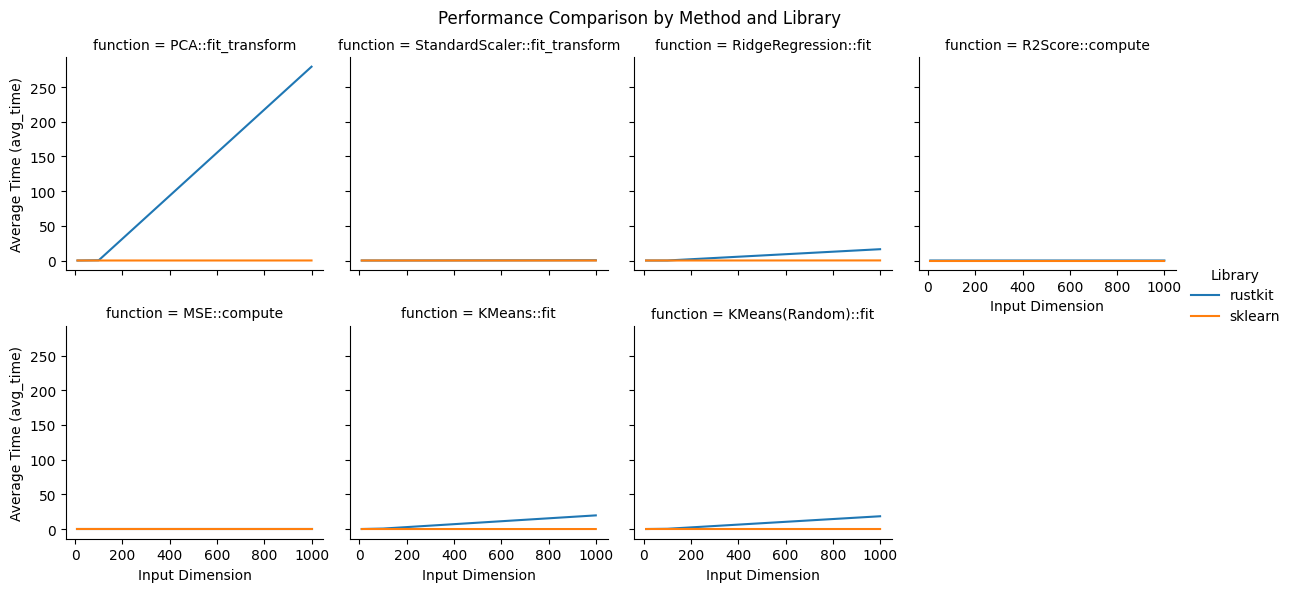

In [41]:
graph = pd.concat([rustkit_python, sklearn_python])

g = sns.FacetGrid(
    graph,
    col="function",
    palette="tab10",
    col_wrap=4,
    height=3
)

g.map_dataframe(sns.lineplot, x="dim", y="avg_time", hue="library")

g.add_legend(title="Library")
g.set_axis_labels("Input Dimension", "Average Time (avg_time)")

plt.subplots_adjust(top=0.9)
g.figure.suptitle("Performance Comparison by Method and Library")

plt.show()

Knowing that some of the difference in runtime can be attributed to the Python bindings themselves, let's see how the Python interop impacted performance by comparing rustkit's runtime from Python vs. Rust.

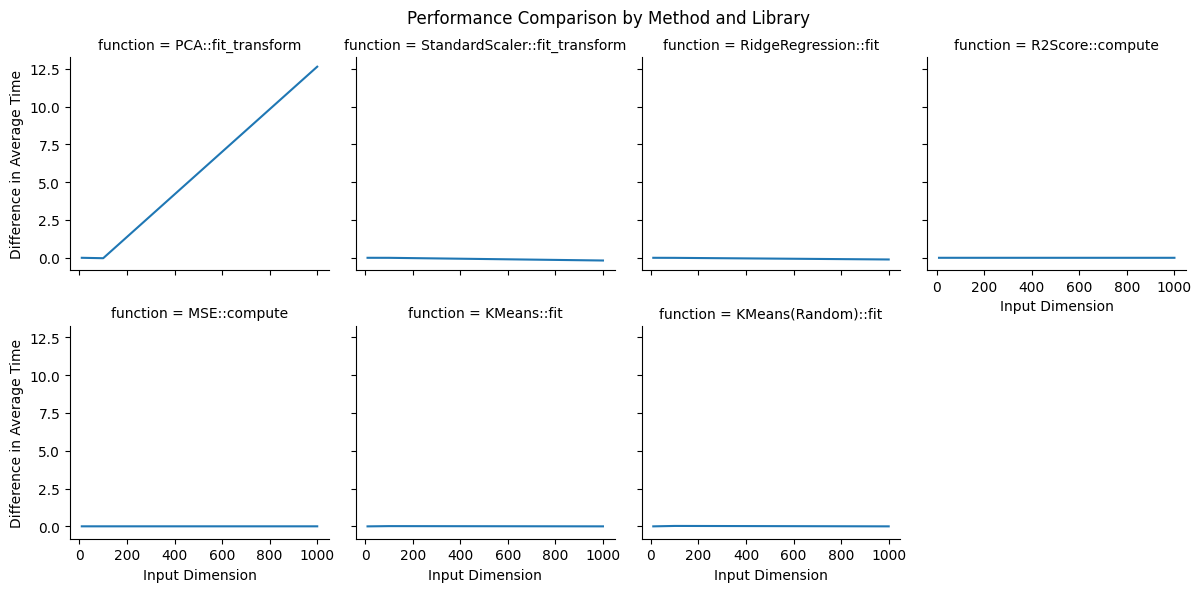

C:\Users\rosew\AppData\Local\Temp\ipykernel_52292\245361814.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rustkit_rust_clean["library"] = "rustkit rust"


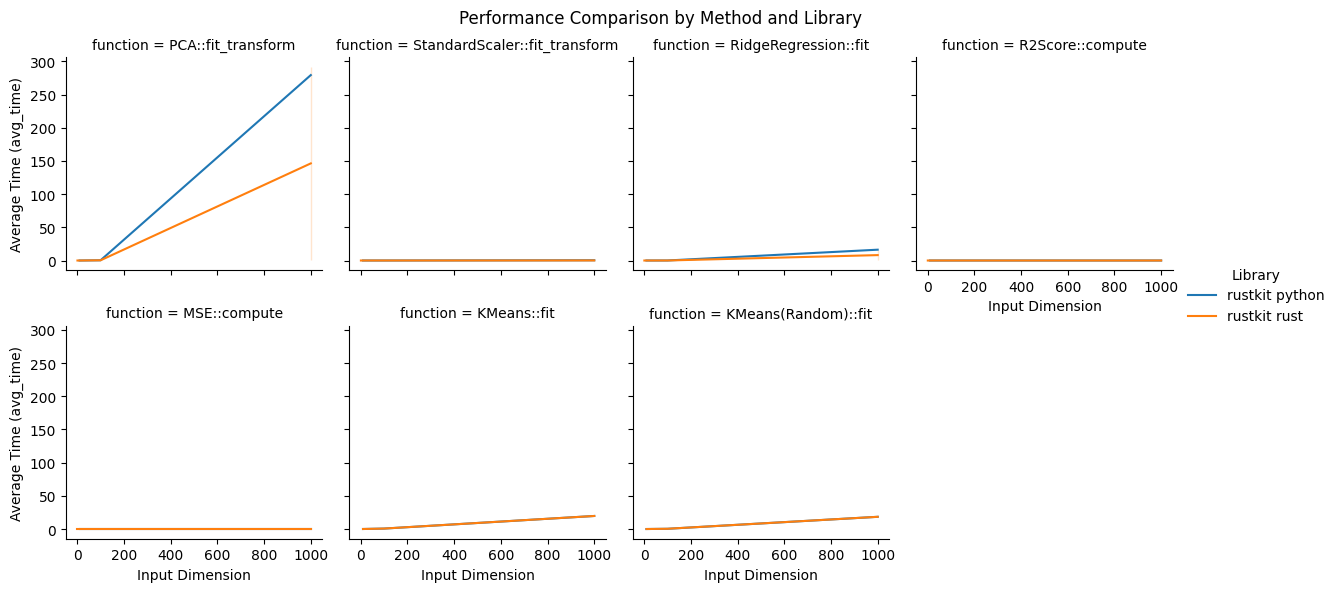

In [48]:
# Difference between rustkit python and rustkit rust
rustkit_diff = rustkit_python.merge(rustkit_rust_clean, on=["function", "nrows", "ncols", "dim"], suffixes=("_rust", "_python"))
rustkit_diff["diff"] = rustkit_diff["avg_time_python"] - rustkit_diff["avg_time_rust"]

# bar chart of difference
g = sns.FacetGrid(
    rustkit_diff,
    col="function",
    palette="tab10",
    col_wrap=4,
    height=3
)

g.map_dataframe(sns.lineplot, x="dim", y="diff")

g.set_axis_labels("Input Dimension", "Difference in Average Time")

plt.subplots_adjust(top=0.9)
g.figure.suptitle("Performance Comparison by Method and Library")

plt.show()

# Plot rustkit python vs rustkit rust
rustkit_python["library"] = "rustkit python"
rustkit_rust_clean["library"] = "rustkit rust"
graph = pd.concat([rustkit_python, rustkit_rust_clean])

g = sns.FacetGrid(
    graph,
    col="function",
    palette="tab10",
    col_wrap=4,
    height=3
)

g.map_dataframe(sns.lineplot, x="dim", y="avg_time", hue="library")

g.add_legend(title="Library")
g.set_axis_labels("Input Dimension", "Average Time (avg_time)")

plt.subplots_adjust(top=0.9)
g.figure.suptitle("Performance Comparison by Method and Library")

plt.show()


Now, let's assess runtime differences between `sklearn` and `rustkit`'s underlying Rust runtime.

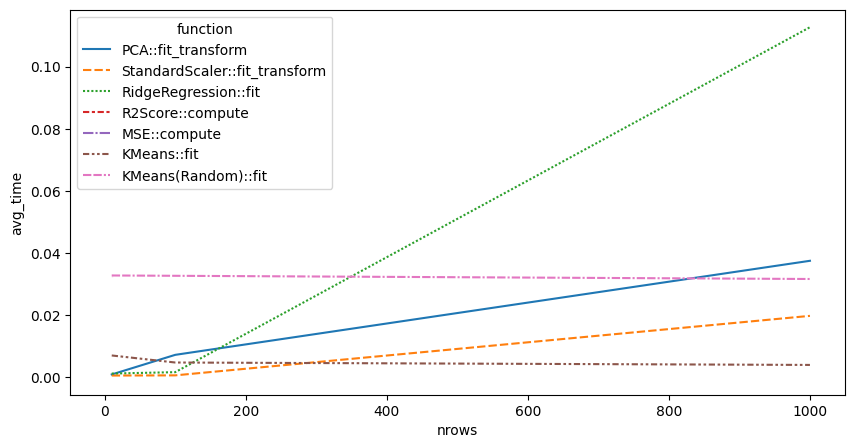

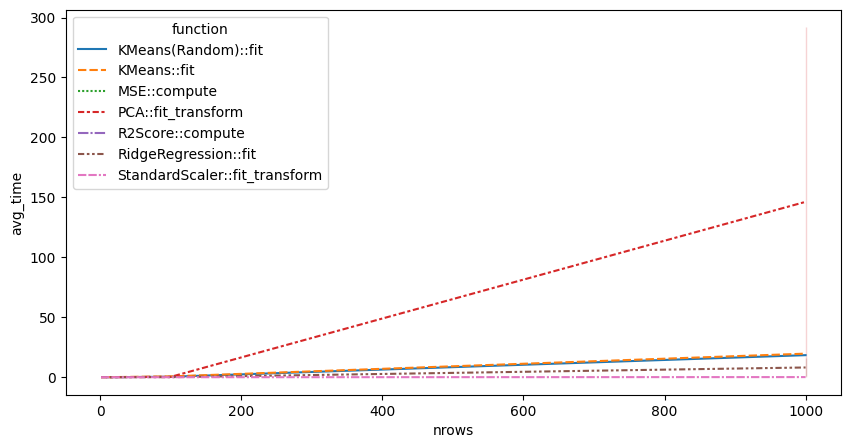

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# sns.lineplot(data=rustkit_rust_clean, x="nrows", y="avg_time", hue="function", style="function", ax=ax)
sns.lineplot(data=sklearn_python, x="nrows", y="avg_time", hue="function", style="function", ax=ax)
# ax.set_xscale("log")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=rustkit_rust_clean, x="nrows", y="avg_time", hue="function", style="function", ax=ax)
# sns.lineplot(data=sklearn_python, x="nrows", y="avg_time", hue="function", style="function", ax=ax)
# ax.set_xscale("log")
plt.show()

### 2. Unit Tests
We tested our implementation fo **correctness** by comparing `rustkit` outputs to `sklearn` outputs.
Specifically, we assessed correctness on the following inputs:
- Inputs of size 1
- Square inputs
- Rectangular inputs
- Large inputs
- Inputs with only negative values
- Inputs with only positive values
- Inputs with both positive and negative values

In [13]:
tests.test_single_input()
print("\n\n")
tests.test_square_input()
print("\n\n")
tests.test_large_input()
print("\n\n")
tests.test_negative_input()
print("\n\n")
tests.test_mixed_input()

SINGLE INPUT
Standard Scaler correctness test failed!
Sklearn Standard Scaler result:
[[0.]]
Rustkit Standard Scaler result:
[[nan]]
Ridge Regression correctness test passed!
R² correctness test failed!
Sklearn R² Score: nan
Rustkit R² Score: -inf
MSE correctness test passed!
PCA correctness test passed!


c:\Users\rosew\anaconda3\envs\rust-final-proj\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\rosew\anaconda3\envs\rust-final-proj\lib\site-packages\sklearn\decomposition\_pca.py:591: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


KMeans - KMeans++ correctness test passed!
KMeans - KMeans++ inertia correctness test passed!
KMeans - Random correctness test passed!
KMeans - Random inertia correctness test passed!



SQUARE INPUT
Standard Scaler correctness test passed!
Ridge Regression correctness test passed!
PCA correctness test passed!
KMeans - KMeans++ correctness test passed!
KMeans - KMeans++ inertia correctness test passed!
KMeans - Random correctness test passed!
KMeans - Random inertia correctness test passed!



LARGE INPUT
Standard Scaler correctness test passed!
Ridge Regression correctness test passed!
R² correctness test passed!
MSE correctness test passed!
PCA correctness test passed!
KMeans - KMeans++ correctness test passed!
KMeans - KMeans++ inertia correctness test passed!
KMeans - Random correctness test passed!
KMeans - Random inertia correctness test passed!



NEGATIVE INPUT
Standard Scaler correctness test passed!
Ridge Regression correctness test passed!
R² correctness test passed!
MSE cor

We tested our **Python bindings** for correctness by comparing the outputs of `main.rs` with `test.py`, where we tested each method for expected rust functionality. We also tested the conversion to/from Rust/Python in isolation by converting in isolation.

In [15]:
def test_converter_vector():
    input_vector = np.array([1.0, 2.0, 3.0, 4.0])
    result = rustkit.converter_vector_test(input_vector)
    
    result_vector = np.array(result)
    
    print("VECTOR TEST")
    print("Input vector:")
    print(input_vector)
    print("Result vector:")
    print(result_vector)
    assert np.array_equal(input_vector, result_vector), "Test failed! Input and output vectors are not equal."
    print("Vector test passed!")

def test_converter_matrix():
    input_matrix = np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    
    result = rustkit.converter_matrix_test(input_matrix)
    
    result_matrix = np.array(result)
    
    print("MATRIX TEST")
    print("Input matrix:")
    print(input_matrix)
    print("Result matrix:")
    print(result_matrix)
    assert np.array_equal(input_matrix, result_matrix), "Test failed! Input and output matrices are not equal."
    print("Matrix test passed!")

In [18]:
test_converter_matrix()
print("\n")
test_converter_vector()

MATRIX TEST
Input matrix:
[[1. 2. 3.]
 [4. 5. 6.]]
Result matrix:
[[1. 2. 3.]
 [4. 5. 6.]]
Matrix test passed!


VECTOR TEST
Input vector:
[1. 2. 3. 4.]
Result vector:
[1. 2. 3. 4.]
Vector test passed!


### 3. Rust Features and Crates Used
The main new crates and language features used were:
- `nalgebra`: for flexible matrix and vector implementations
- `numpy`: Rust objects closely related to Python NumPy objects, used as an interlayer between `nalgebra` and Python
- `pyo3`: Provides Rust bindings for Python

In Python, we used `maturin` to build crates as python packages.

#### 3.1 Brief overview of `nalgebra`


#### 3.2 Using `pyo3` and `maturin` to package `rustkit` 

### 4. Reflection on Project and Rust as a whole
1. It's harder than we thought to improve runtime!
2. 